This notebook is written to prototype a conversion from the "ACAPS" humdata.org database into the epidemicforecasting.org format.

For anything that is in the source ACAPS that we'd _like_ to be in target EF, we'll write a function to convert it.

This includes data that EF already has, so that we can fill in any gaps.



In [145]:
import pandas as pd
import numpy as np
import re


In [2]:
source_data = pd.read_csv("../../../data/epidemicforecasting/20200416-acaps-covid-19-goverment-measures-dataset-v8.xlsx - Database.csv")

In [3]:
source_data.sample(5)

,ID,COUNTRY,ISO,ADMIN_LEVEL_NAME,PCODE,REGION,LOG_TYPE,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,NON_COMPLIANCE,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source
1905,1638,France,FRA,NaN,NaN,Europe,Introduction / extension of measures,Movement restrictions,Border closure,No,Foreign citizens that are not permanents resid...,Not applicable,18/03/2020,Ministry for Europe and Foreign Affairs,Government,https://www.diplomatie.gouv.fr/en/coming-to-fr...,23/03/2020,NaN
3919,997,Papua New Guinea,PNG,NaN,NaN,Pacific,Introduction / extension of measures,Public health measures,Introduction of isolation and quarantine policies,Yes,14-day quarantine and medical clearances for a...,NaN,16/03/2020,RNZ,Media,https://www.rnz.co.nz/international/pacific-ne...,20/03/2020,NaN
399,2734,Austria,AUT,NaN,NaN,Europe,Introduction / extension of measures,Public health measures,Strengthening the public health system,No,Local production sites established for protect...,Not applicable,23/03/2020,Chamber of Commerce,Government,https://news.wko.at/news/oesterreich/WKOe-Kopf...,27/03/2020,NaN
5516,2080,Zambia,ZMB,NaN,NaN,Africa,Introduction / extension of measures,Social distancing,Schools closure,No,"All schools, colleges and universities to be c...",NaN,20/03/2020,Lusaka Times,Media,https://www.lusakatimes.com/2020/03/17/zambia-...,24/03/2020,NaN
2605,3193,Japan,JPN,NaN,NaN,Asia,Introduction / extension of measures,Public health measures,General recommendations,No,Avoid all travel to Zhejiang Province in China...,NaN,14/02/2020,Japan MoFA,Government,https://www.mofa.go.jp/press/kaiken/kaikene4_0...,31/03/2020,NaN


In [4]:
source_data.COUNTRY.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'China, Hong Kong Special Administrative Region', 'Colombia',
       'Comoros', 'Congo', 'Congo DR', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Czech republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Gren

Now let's see what the target data source looks like.

In [219]:
ef_cm = pd.read_csv(
    "../../../data/epidemicforecasting/epimodel-covid-data/sources/COVID 19 Containment measures data.csv",
    parse_dates=['Date Start','Date end intended']).dropna(subset=['Country'])

    

In [6]:
ef_cm.sample(5)

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
594,494,pendlers,Czechia,2020-03-19,NaT,"Since 19 March 2020, from 00.00 hours, the so-...",NaN,NaN,NaN,domestic travel limitation,NaN,https://koronavirus.mzcr.cz/vyvoj-udalosti-v-c...,NaN,NaN,NaN,NaN
1093,NaN,NaN,Croatia,2020-03-19,2020-04-19,The Croatian government is limiting entry to t...,NaN,NaN,NaN,outdoor gatherings banned,5.0,https://www.thestandard.com.hk/breaking-news/s...,NaN,NaN,NaN,NaN
747,NaN,note that it is not oficially cancelled by gov...,Germany,2020-03-09,NaT,Federal Minister of Health Jens Spahn encourag...,NaN,NaN,NaN,outdoor gatherings banned,1000.0,https://www.bundesregierung.de/breg-de/themen/...,NaN,NaN,NaN,NaN
1299,NaN,NaN,India,2020-03-15,NaT,Indian Prime Minister Narendra Modi proposed s...,NaN,NaN,NaN,international aid,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
84,NaN,NaN,Slovenia,2020-03-16,NaT,The Government of the Republic of Slovenia dec...,NaN,NaN,NaN,"new testing method commenced, testing criteria",NaN,https://www.gov.si/en/topics/coronavirus-disea...,NaN,NaN,NaN,NaN


OK great. So what if we picked one category where `ACAPS` was useful, wrote a mapping from that category to one in `ef_cm`, converted it to `ef_cm` format, and then imported it into the dataset itself?

## Explore ACAPS categories

ACAPS follow a rough hierarchy of "category" and "measure".

First, the data needs a bit of tidying up - let's trim whitespace out of the relevant columns.

In [7]:
source_data.CATEGORY = source_data.CATEGORY.str.strip()
source_data.MEASURE = source_data.MEASURE.str.strip()
#and because we want source_data without a sublocale to merge we're going to change NaN to a ''.
#need to change NA to a zero-length string so that it'll list as a unique item.
source_data.loc[:,"ADMIN_LEVEL_NAME_MERGEABLE"]=source_data.ADMIN_LEVEL_NAME
source_data.loc[pd.isnull(source_data.ADMIN_LEVEL_NAME),"ADMIN_LEVEL_NAME_MERGEABLE"]=''

#there's a few source data items with a date misssing - let's remove those.
source_data = source_data.loc[source_data['DATE_IMPLEMENTED'].isnull()==False]

Here's list of each CATEGORY with all of the MEASURE items in each category.

In [8]:
for c in source_data.CATEGORY.unique():
    print(c)
    print(source_data.loc[source_data.CATEGORY==c,'MEASURE'].unique())
    print("\n")

Public health measures
['Health screenings in airports and border crossings'
 'Introduction of isolation and quarantine policies' 'Awareness campaigns'
 'Strengthening the public health system'
 'Other public health measures enforced' 'General recommendations'
 'Requirement to wear protective gear in public'
 'Amendments to funeral and burial regulations' 'Testing policy'
 'Psychological assistance and medical social work'
 'Mass population testing' 'testing policy'
 'strengthening the public health system']


Governance and socio-economic measures
['Emergency administrative structures activated or established'
 'Limit product imports/exports' 'State of emergency declared'
 'Economic measures' 'Military deployment']


Social distancing
['Limit public gatherings' 'Schools closure'
 'Changes in prison-related policies' 'Public services closure'
 'limit public gatherings']


Movement restrictions
['Border closure' 'Border checks' 'International flights suspension'
 'Surveillance and monit

Lockdown is a good one to start with. `ef` coverage is likely to be quite good, which makes it a useful test case. Let's try importing those.

## Explore EF data

array(['Vietnam', 'South Korea', 'Israel', 'Hong Kong', 'China',
       'Belgium', 'Luxembourg', 'Andorra', 'Austria', 'Denmark', 'Greece',
       'Portugal', 'Russia', 'Romania', 'Italy', 'Albania', 'Mexico',
       'Croatia', 'Egypt', 'Palestine', 'Singapore', 'Iraq', 'Hungary',
       'Cyprus', 'Namibia', 'South Africa', 'Georgia'], dtype=object)

In [ ]:
ef_cm_n.loc[ef_cm_n.Keywords=='school closure','Country'].unique()

In [198]:
ef_cm_n.Keywords.unique()

array(['university closure',
       'international traveller quarantine - risk countries, traveller testing',
       'nursery school closure, school closure, university closure',
       'blanket isolation - symptoms', 'isolation advice to elderly',
       'public announcement, social distancing',
       'end of testing, testing criteria tightened',
       'international traveller quarantine - risk countries',
       'outbound travel warning', nan, 'school closure',
       'international travel ban - risk countries',
       'international traveller screening - risk countries',
       'religious activity limitations',
       'international traveller screening - all countries',
       'epidemic data', 'personal hygiene, social distancing',
       'remote work, social distancing',
       'special management arrangements', 'remote schooling',
       'discharged patient isolation',
       'hospital specialisation, hospital treatment, task group, treatment capacity',
       'public announceme

## Importing single category from ACAPS to ef format

In [9]:
source_data.loc[(source_data.CATEGORY=="Lockdown") & (source_data.MEASURE=="Full lockdown"),]

,ID,COUNTRY,ISO,ADMIN_LEVEL_NAME,PCODE,REGION,LOG_TYPE,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,NON_COMPLIANCE,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source,ADMIN_LEVEL_NAME_MERGEABLE
105,1982,Algeria,DZA,NaN,NaN,Africa,Introduction / extension of measures,Lockdown,Full lockdown,Yes,Bilda (complete confinement - all movement in ...,NaN,23/03/2020,Gardaworld,Other organisations,https://www.garda.com/crisis24/news-alerts/325...,24/03/2020,NaN,
114,5409,Algeria,DZA,Blida,NaN,Africa,Introduction / extension of measures,Lockdown,Full lockdown,Yes,Blida extended until at least 19. april 2020,Not available,01/04/2020,International SOS,Other organisations,https://pandemic.internationalsos.com/2019-nco...,15/04/2020,NaN,Blida
206,4666,Antigua and Barbuda,ATG,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,"A 24 Hour curfew from Thursday, April 2 from 1...",Other (add in comments),02/04/2020,AB govt.,Government,https://ab.gov.ag/pdf/covid_news/mar_31_2020_2...,10/04/2020,NaN,
207,4736,Antigua and Barbuda,ATG,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,extension of 24 hr curfew from until April 16 ...,Other (add in comments),09/04/2020,AB govt.,Government,https://ab.gov.ag/pdf/covid_news/Essential_Ser...,10/04/2020,NaN,
460,4741,Azerbaijan,AZE,NaN,NaN,Asia,Introduction / extension of measures,Lockdown,Full lockdown,Yes,only allowed to leave place of residences unde...,Not available,24/03/2020,Travel Authority,Government,https://azerbaijan.travel/covid-19-en,10/04/2020,NaN,
496,4774,Bahamas,BHS,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,"24-hour curfew, with some exceptions for esse...",Not available,24/03/2020,Prime Minister Office,Government,http://www.bahamas.gov.bs/wps/portal/public/go...,10/04/2020,NaN,
502,4884,Bahamas,BHS,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,All residents will be placed on a 24-hour curf...,Not available,24/03/2020,Bahamas Govt.,Government,http://www.bahamas.gov.bs/wps/portal/public/go...,12/04/2020,NaN,
509,4891,Bahamas,BHS,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,Emergency Order remains in effect until Wedne...,Not available,31/03/2020,Bahamas Govt.,Government,http://www.bahamas.gov.bs/wps/portal/public/go...,12/04/2020,NaN,
622,5203,Barbados,BRB,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,"24-hour curfew from 6:00 p.m. on Friday, April...",Other (add in comments),03/04/2020,Gov. Info Services,Government,https://gisbarbados.gov.bb/blog/24-hour-curfew...,14/04/2020,NaN,
1992,3866,Georgia,GEO,NaN,NaN,Europe,Introduction / extension of measures,Lockdown,Full lockdown,No,Nationwide lockdown,Not available,30/03/2020,Civil.ge,Media,https://civil.ge/archives/344761,05/04/2020,https://pandemic.internationalsos.com/2019-nco...,


In [10]:
source_data.columns

Index(['ID', 'COUNTRY', 'ISO', 'ADMIN_LEVEL_NAME', 'PCODE', 'REGION',
       'LOG_TYPE', 'CATEGORY', 'MEASURE', 'TARGETED_POP_GROUP', 'COMMENTS',
       'NON_COMPLIANCE', 'DATE_IMPLEMENTED', 'SOURCE', 'SOURCE_TYPE', 'LINK',
       'ENTRY_DATE', 'Alternative source', 'ADMIN_LEVEL_NAME_MERGEABLE'],
      dtype='object')

In [11]:
ef_cm.columns

Index(['ID', 'Applies To', 'Country', 'Date Start', 'Date end intended',
       'Description of measure implemented', 'Exceptions', 'Implementing City',
       'Implementing State/Province', 'Keywords', 'Quantity', 'Source',
       'Target city', 'Target country', 'Target region', 'Target state'],
      dtype='object')

We'll need to map country names. If we assume each source has consistent country names then we can create a mapping CSV that records the names. I'll do this in a Gsheet and then save to CSV.

## Sort out country names

In [12]:
pd.DataFrame(ef_cm.Country.unique()).to_csv("../../../data/epidemicforecasting/ef_countryname_lexicon.csv")


#https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count
grouping_cols = ["COUNTRY","ISO","ADMIN_LEVEL_NAME_MERGEABLE"]
source_data_grouped = pd.DataFrame(source_data.loc[:,grouping_cols]).groupby(grouping_cols).size().reset_index().rename(columns={0:'count'})
print(source_data_grouped.sample(5))
source_data_grouped.to_csv("../../../data/epidemicforecasting/acaps_countryname_lexicon.csv") 

                    COUNTRY  ISO ADMIN_LEVEL_NAME_MERGEABLE  count
87                    Chile  CHL        Region de los Lagos      1
306                Pakistan  PAK                                14
61   Bosnia and Herzegovina  BIH           Republika Srpska      4
402             Switzerland  CHE                                43
234                   Libya  LBY              Eastern Libya      1


In [13]:
region_lexicon_conversion = pd.read_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ef_region_lexicon_conversion.csv")

In [14]:
region_lexicon_conversion.sample(5)

,EF_LOCALE,EF_SUBLOCALE,ACAPS_COUNTRY,ACAPS_ISO,ACAPS_ADMIN_LEVEL_NAME,Notes
9,NaN,NaN,Antigua and Barbuda,ATG,NaN,NaN
245,NaN,NaN,Spain,ESP,Basque Country,NaN
140,NaN,NaN,Kiribati,KIR,NaN,NaN
311,NaN,NaN,Zambia,ZMB,NaN,NaN
111,NaN,NaN,Guinea-Bissau,GNB,NaN,NaN


## Get EF-formatted data from ACAPS

In [15]:
source_data.efc_Keywords=""

In [16]:
def from_acaps_to_ef_lockdown(source_data):
    #let's start with only handling lockdown rows; we can expand applicability from there.
    #the source data has country and ISO information for country.
    #and for now, let's start with handling only top-level ACAPS data
    #it does do regional-level breakdowns for many countries
    #that's good data to use.
    
    #OK, great, so now we have merged in the region lexicon.
    acaps_region_grouping_cols =["COUNTRY","ISO","ADMIN_LEVEL_NAME_MERGEABLE"]
    region_lexicon_conversion.loc[pd.isnull(region_lexicon_conversion.ACAPS_ADMIN_LEVEL_NAME),"ACAPS_ADMIN_LEVEL_NAME"]=''

    source_data = source_data.merge(region_lexicon_conversion,
                      left_on=acaps_region_grouping_cols,
                      right_on=["ACAPS_COUNTRY","ACAPS_ISO","ACAPS_ADMIN_LEVEL_NAME"]
                     )

    source_data["efc_Keywords"]=""
    
    conversion_sheet = pd.read_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ACAPS_ef_conversion_sheet.csv")

    
    for index, row in conversion_sheet.iterrows():

        measure = row["ACAPS"]
        #print("row:")
        #print(row)
    
        #identify rows to work with for this particular category
        append_rows = (
            #(source_data.CATEGORY==category) & 
            (source_data.MEASURE==measure)
        )

        #if there is no data in the keyword list, just set the list to contain the new keyword
        #if there is data, then append.
        append_rows_nonempty = (append_rows & (source_data.loc[:,"efc_Keywords"].str.len()>0))

        source_data.loc[append_rows_nonempty,
                       "efc_Keywords"] = (
            [', '.join([kl, row["ef_tag"]]) for kl in source_data.loc[append_rows_nonempty,"efc_Keywords"]]
        )

        source_data.loc[append_rows_nonempty,"efc_confidence"] = row["confidence"]

        #items that we can transfer over generally.
        source_data.loc[append_rows & (source_data.loc[:,"efc_Keywords"].str.len()==0),
                       "efc_Keywords"] = row["ef_tag"]

    source_data['efc_Date Start'] =     pd.to_datetime(source_data['DATE_IMPLEMENTED'])
    source_data['efc_Description of measure implemented'] = source_data["COMMENTS"]

    #we could fill in state/province whereever the source data has an ADMIN_LEVEL_NAME
    source_data['efc_Implementing State/Province'] = source_data["ADMIN_LEVEL_NAME"]
    source_data['efc_Country'] = source_data["EF_LOCALE"]#EF_LOCALE source_data["COUNTRY"]
    source_data.loc[source_data.loc[:,'efc_Country'].isnull(),'efc_Country'] = (
        source_data.loc[source_data.loc[:,'efc_Country'].isnull(),"COUNTRY"]
    )
        #use the country name from the ACAPS dataset if we don't have 

    source_data['efc_Source'] = source_data["SOURCE"] + " (" +  source_data["SOURCE_TYPE"] + ", " + source_data["LINK"] 

    #now we take all the columns that have "efc_" at the beginning in source_data, and that's our output
    efc_cols = list(filter(re.compile("^efc_").match,source_data.columns))
    #only the rows where we've identified a tab
    efc_out = source_data.loc[source_data['efc_Keywords']!='',efc_cols]
    efc_out.columns = [s.replace("efc_","") for s in efc_cols]

    #acaps keywords are all lower case.
    efc_out.Keywords = efc_out.Keywords.str.lower()
        
    return(efc_out)



In [17]:
ef_from_acaps = from_acaps_to_ef_lockdown(source_data)

ef_from_acaps

,Keywords,confidence,Date Start,Description of measure implemented,Implementing State/Province,Country,Source
0,international traveller screening - risk count...,NaN,2020-12-02,NaN,NaN,Afghanistan,"Ministry of Health (Government, https://moph.g..."
1,coronavirus education activities,NaN,2020-12-02,NaN,NaN,Afghanistan,"Ministry of Health (Government, https://moph.g..."
4,international travel ban - risk countries,NaN,2020-02-24,Closure of borders with Iran,NaN,Afghanistan,"Guardian (Media, https://www.theguardian.com/g..."
5,hospital specialisation - partial,NaN,2020-01-03,NaN,NaN,Afghanistan,"OCHA (UN, https://reliefweb.int/sites/reliefwe..."
8,coronavirus education activities,NaN,2020-01-24,MoPH begins announcements on their facebook to...,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
9,international traveller screening - risk count...,NaN,2020-01-26,Health teams at airports will check passengers...,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
11,international traveller screening - risk count...,NaN,2020-01-27,Health screenings of all passengers at airports.,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
13,coronavirus education activities,NaN,2020-04-02,"Print, publishing and sending advertising mate...",NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
14,hospital specialisation - partial,NaN,2020-04-02,The Ministry of public health has created the ...,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
16,coronavirus education activities,NaN,2020-08-02,the launch of education programs for doctors t...,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."


In [18]:
ef_from_acaps.to_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ACAPS_as_ef.csv")

## Quantify the overlap and prepare for combining

In [19]:
merge_cols=['Keyword','Country','Date Start']

In [20]:


#### Combine the data sources

def get_ef_by_keyword(ef_data):

    ef_keyword_list = ef_data.Keywords.str.split(", ",expand=True).reset_index().melt(id_vars=["index"])
    ef_keyword_list = ef_keyword_list.loc[ef_keyword_list.value.isnull()==False,["index","value"]]
    ef_keyword_list.columns = ['event_index','Keyword']

    #now merge it back in with ef_from_acaps
    ef_by_keyword = ef_keyword_list.merge(ef_data,left_on='event_index',right_index=True)
    ef_by_keyword.drop('Keywords',axis=1, inplace=True)
    return(ef_by_keyword)

ef_acaps_by_keyword = get_ef_by_keyword(ef_from_acaps)
ef_cm_by_keyword = get_ef_by_keyword(ef_cm)


datasource_comparison = ef_cm_by_keyword.loc[:,merge_cols].merge(ef_acaps_by_keyword.loc[:,merge_cols], how = 'outer' ,indicator=True)#.loc[lambda x : x['_merge']=='left_only']
#df = df1.merge(df2, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
datasource_comparison._merge.value_counts()

right_only    3484
left_only     2053
both            32
Name: _merge, dtype: int64

### EF deep dive

In [202]:
ef_cmk_n = ef_cm_by_keyword.loc[ef_cm_by_keyword.Country.str.contains('US:')==False,:]
ef_cmk_n.loc[ef_cmk_n.Keyword=='school closure','Country'].unique()


59

In [206]:
ef_cmk_n.loc[ef_cmk_n.Keyword=='school closure','Country'].unique()

array(['United Kingdom', 'Vietnam', 'South Korea', 'Sweden', 'Slovenia',
       'Israel', 'Hong Kong', 'China', 'Italy', 'Czechia', 'Spain',
       'France', 'Belgium', 'Luxembourg', 'Portugal', 'Albania',
       'Andorra', 'Austria', 'Azerbaijan', 'Bosnia and Herzegovina',
       'Bulgaria', 'Denmark', 'Finland', 'Estonia', 'Hungary', 'Latvia',
       'Lithuania', 'Moldova', 'Malta', 'Monaco', 'Greece', 'Iceland',
       'Netherlands', 'Macedonia', 'Ireland', 'Turkey', 'Poland',
       'Ukraine', 'Serbia', 'Slovakia', 'Switzerland', 'Norway',
       'Germany', 'Iran', 'Russia', 'Romania', 'Mexico', 'Croatia',
       'Egypt', 'Palestine', 'Singapore', 'Iraq', 'Nepal', 'Cyprus',
       'Namibia', 'South Africa', 'Morocco', 'Georgia', 'Uganda'],
      dtype=object)

In [207]:
len(ef_cmk_n.loc[ef_cmk_n.Keyword=='school closure','Country'].unique())

59

In [211]:
len(ef_cmk_n.loc[ef_cmk_n.Keyword.str.contains('healthcare'),'Country'].unique())

1

In [221]:
ef_cm.loc[ef_cm.Keywords.str.contains('hospital',na=False),:]

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
30,668,NaN,South Korea,2020-03-02,NaT,"For patients with COVID-19 positive, state and...",NaN,NaN,NaN,"hospital specialisation, hospital treatment, t...",NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN
46,627,NaN,South Korea,2020-02-21,NaT,Response team disinfecting the hospital and ch...,NaN,NaN,"Daegu, Gyeongbook Province","hospital specialisation, public facility cleaning",NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN
54,NaN,NaN,South Korea,2020-03-13,NaT,Use designated public relief hospitals- where ...,NaN,NaN,NaN,hospital specialisation,NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN
174,29,NaN,China,2020-02-01,NaT,"Huanggang, Hubei converted Dabie Mountain Regi...",NaN,Huanggong,Hubei,"hospital construction, treatment capacity",NaN,https://web.archive.org/web/20200202065358/htt...,NaN,NaN,NaN,NaN
183,38,NaN,China,2020-02-02,NaT,Huoshenshan Hospital completed construction in...,NaN,NaN,Hubei,"hospital construction, hospital specialisation",NaN,https://web.archive.org/web/20200202061233/htt...,NaN,NaN,NaN,NaN
194,49,NaN,China,2020-02-05,NaT,Hubei released an additional ¥200 million (US$...,NaN,NaN,Hubei,"hospital construction, hospital specialisation...",NaN,https://web.archive.org/web/20200205135302/htt...,NaN,NaN,NaN,NaN
195,50,NaN,China,2020-02-05,NaT,The first shelter hospital[534] is put into use,NaN,Wuhan,Hubei,"hospital construction, hospital specialisation...",NaN,https://web.archive.org/web/20200205135301/htt...,NaN,NaN,NaN,NaN
210,65,NaN,China,2020-02-08,NaT,Leishenshan Hospital begins operation.,NaN,NaN,Leishenshan,"hospital construction, treatment capacity",NaN,https://www.jiemian.com/article/3959045.html,NaN,NaN,NaN,NaN
276,127,NaN,Czechia,2020-03-10,NaT,"the Security Council met. Subsequently, the Mi...","inpatient care, which is provided to minors, p...",NaN,NaN,"social distancing, visiting in hospital banned",NaN,https://koronavirus.mzcr.cz/vyvoj-udalosti-v-c...,NaN,NaN,NaN,NaN
290,151,NaN,Romania,2020-01-22,NaT,Romanian government announced several preventi...,NaN,NaN,NaN,hospital specialisation,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN


In [222]:
len(ef_cmk_n.loc[ef_cmk_n.Keyword.str.contains('hospital'),'Country'].unique())

11

In [210]:
ef_cmk_n.Keyword.

,event_index,Keyword,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Quantity,Source,Target city,Target country,Target region,Target state
0,0,university closure,163,NaN,Austria,2020-03-16,NaT,On 10 March 2020 government announced that all...,NaN,NaN,NaN,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
1,1,international traveller quarantine - risk coun...,132,NaN,Germany,2020-02-01,NaT,"102 German citizens and 26 relatives, all of w...",NaN,NaN,NaN,0.0001,https://www.tagesschau.de/inland/coronavirus-g...,NaN,NaN,NaN,NaN
1593,1,traveller testing,132,NaN,Germany,2020-02-01,NaT,"102 German citizens and 26 relatives, all of w...",NaN,NaN,NaN,0.0001,https://www.tagesschau.de/inland/coronavirus-g...,NaN,NaN,NaN,NaN
2,2,nursery school closure,578,NaN,United Kingdom,2020-03-20,NaT,"All schools, nurseries and colleges closed.",NaN,NaN,NaN,NaN,https://www.theguardian.com/world/2020/mar/18/...,NaN,NaN,NaN,NaN
1594,2,school closure,578,NaN,United Kingdom,2020-03-20,NaT,"All schools, nurseries and colleges closed.",NaN,NaN,NaN,NaN,https://www.theguardian.com/world/2020/mar/18/...,NaN,NaN,NaN,NaN
3186,2,university closure,578,NaN,United Kingdom,2020-03-20,NaT,"All schools, nurseries and colleges closed.",NaN,NaN,NaN,NaN,https://www.theguardian.com/world/2020/mar/18/...,NaN,NaN,NaN,NaN
3,3,blanket isolation - symptoms,372,NaN,United Kingdom,2020-03-16,NaT,If one person in any household has a persisten...,NaN,NaN,NaN,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN
4,4,isolation advice to elderly,357,NaN,United Kingdom,2020-03-16,NaT,"By the weekend, those with the most serious he...",NaN,NaN,NaN,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN
5,5,public announcement,356,NaN,United Kingdom,2020-03-16,NaT,Everyone should avoid gatherings with friends ...,NaN,NaN,NaN,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN
1597,5,social distancing,356,NaN,United Kingdom,2020-03-16,NaT,Everyone should avoid gatherings with friends ...,NaN,NaN,NaN,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN


## Compare this against EF

In [21]:
ef_cm.Keywords.value_counts().sample(5)

remote schooling, school closure, university closure     1
domestic travel resumed                                  4
first case                                              30
social distancing, visiting in hospital banned           1
household quarantine                                     1
Name: Keywords, dtype: int64

How much overlap do we have between the two?

In [22]:
ef_cm.loc[:,["Country","Keywords","Date Start"]].sample(10)

,Country,Keywords,Date Start
452,Guernsey,"case reporting, first case",2020-03-09
620,Russia,international travel ban - risk countries,2020-03-01
246,China,"compulsory isolation, natural village quarantine",2020-02-16
91,Israel,outbound travel warning,2020-02-26
634,US:N Carolina,outdoor gatherings banned,2020-03-14
645,US: Oregon,"school closure, university closure",2020-03-18
584,Czechia,business resumed,2020-03-16
1043,US:Maryland,school closure,2020-03-16
1100,Singapore,religious activity cancellation,2020-03-26
1176,Spain,"school closure, university closure",2020-03-11


In [23]:
ef_from_acaps.loc[:,["Country","Keywords","Date Start"]].sample(10)

,Country,Keywords,Date Start
1656,Finland,international traveller screening - risk count...,2020-03-25
4773,Uganda,"domestic travel limitation, domestic traveller...",2020-03-25
1064,Colombia,economic stimulus,2020-09-04
3768,Poland,economic stimulus,2020-08-04
3918,Rwanda,international travel ban - risk countries,2020-03-20
462,Bahrain,limited nonessential business closure,2020-03-15
4872,United States,hospital specialisation - partial,2020-06-03
2550,Lebanon,state of emergency,2020-03-16
4272,Spain,hospital specialisation - partial,2020-03-17
3722,Philippines,international travel ban - risk countries,2020-06-04


#### What broad overlap is there between the datasets?

In [24]:
ef_freq_count = pd.DataFrame(ef_cm.Keywords.value_counts())
acaps_freq_count = pd.DataFrame(ef_from_acaps.Keywords.value_counts())

unique items in the ef database only

In [25]:
#
ef_freq_count.index[~ef_freq_count.index.isin(acaps_freq_count.index)]

Index(['testing numbers total', 'outdoor gatherings banned', 'school closure',
       'nonessential business suspension', 'sports cancellation',
       'case reporting, first case', 'first case', 'public announcement',
       'school closure, university closure',
       'closure nonessential stores, nonessential business suspension',
       ...
       'emergency declaration, special management arrangements',
       'remote work, social distancing',
       'public hygiene, public mask and hygiene supply',
       'special management arrangements, state of emergency',
       'cohort isolation - no symptoms, public facility cleaning',
       'test symptomatic, testing criteria',
       'social distancing, sports cancellation, weddings canceled',
       'cultural activity limitation, indoor gatherings banned, outdoor gatherings banned, religious activity limitations, restaurant limitations',
       'contacts traced total, research', 'moves of medical material'],
      dtype='object', length

unique items in the acaps database only

In [26]:
#
acaps_freq_count.index[~acaps_freq_count.index.isin(ef_freq_count.index)]

Index(['hospital specialisation - partial',
       'limited nonessential business closure',
       'domestic travel limitation, domestic traveller quarantine, domestic travel ban',
       'military takeover', 'funeral hygiene', 'test all'],
      dtype='object')

items in both databases

In [27]:
#
df_overlap = pd.merge(
    ef_freq_count,
    acaps_freq_count,
    left_index=True,right_index=True,
    how='inner',suffixes=('_ef','_acaps')
)


In [28]:
df_overlap.index

Index(['international travel ban - risk countries',
       'international travel ban - all countries',
       'international traveller screening - risk countries',
       'blanket curfew - no symptoms', 'domestic travel limitation',
       'economic stimulus', 'coronavirus education activities',
       'state of emergency', 'risk communication'],
      dtype='object')

What overlap is there in country coverage?

In [29]:
ef_c_freq_count = pd.DataFrame(ef_cm.Country.value_counts())
acaps_c_freq_count = pd.DataFrame(ef_from_acaps.Country.value_counts())

Regions only in the EF dataset:

In [30]:
regions_ef = ef_c_freq_count.index[~ef_c_freq_count.index.isin(acaps_c_freq_count.index)]
print(len(regions_ef))
print([x for x in regions_ef.sort_values()])

42
['Andorra', 'European Union', 'Faroe Islands', 'Guernsey', 'Hong Kong', 'Jersey', 'Kosovo', 'Macau', 'Moldova', 'Monaco', 'North Korea', 'San Marino', 'Singapore', 'Taiwan', 'US: Arizona', 'US: Connecticut', 'US: Florida', 'US: Illinois', 'US: Indiana', 'US: Massachussets', 'US: Michigan', 'US: Nevada', 'US: Oregon', 'US: Pennsylvania', 'US: S Carolina', 'US: Virginia', 'US: Wisconsin', 'US:Alabama', 'US:Alaska', 'US:Arkansas', 'US:California', 'US:Colorado', 'US:Delaware', 'US:Georgia', 'US:Idaho', 'US:Maryland', 'US:N Carolina', 'US:New Jersey', 'US:New York', 'US:Utah', 'US:Washington', 'Vatican City']


Regions only in the ACAPS dataset:

In [31]:
regions_acaps=acaps_c_freq_count.index[~acaps_c_freq_count.index.isin(ef_c_freq_count.index)]
print(len(regions_acaps))
print([x for x in regions_acaps.sort_values()])

101
['Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Bahamas', 'Bangladesh', 'Barbados', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Comoros', 'Congo', 'Congo DR', 'Cuba', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Fiji', 'Gabon', 'Gambia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Jamaica', 'Jordan', 'Kenya', 'Kiribati', 'Lao PDR', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Maldives', 'Mali', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Micronesia', 'Mongolia', 'Mozambique', 'Myanmar', 'Nauru', 'Nicaragua', 'Niger', 'Nigeria', 'Oman', 'Palau', 'Papua New Guinea', 'Paraguay', 'Peru', 'Russian Federation', 'Rwanda', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'Saudi Arabia'

and countries in both databases

In [32]:
df_c_overlap = pd.merge(
    ef_c_freq_count,
    acaps_c_freq_count,
    left_index=True,right_index=True,
    how='inner',suffixes=('_ef','_acaps')
)
df_c_overlap

,Country_ef,Country_acaps
China,122,33
Italy,84,36
South Korea,65,9
Nepal,56,30
Czechia,47,26
Albania,39,30
Germany,33,35
Hungary,30,44
Croatia,29,21
Greece,26,14


#### What overlap is there between specific events?

An event is a particular category (keyword) occuring on a particular day (date) in a particular location.

We do need to split out listed keywords.
That means reshaping the ef format so that it has a one row per keyword type

Now, we need to select the columns - keyword, date, location, and then just look for how many are overlapped between the two datasets.


In [33]:

common_rows = (
    ef_acaps_by_keyword.loc[:,merge_cols].merge(
        ef_cm_by_keyword.loc[:,merge_cols]
    )
)

print(common_rows.sample(10))
print(len(common_rows))

                                      Keyword      Country Date Start
5                           economic stimulus        Egypt 2020-03-17
13               blanket curfew - no symptoms       Greece 2020-03-23
23                         state of emergency      Romania 2020-03-16
7                           economic stimulus      Germany 2020-03-23
20  international travel ban - risk countries    Macedonia 2020-03-13
31                         state of emergency  Switzerland 2020-03-16
9                           economic stimulus      Germany 2020-03-23
22                         state of emergency      Romania 2020-03-16
15                         risk communication  South Korea 2020-03-18
25  international travel ban - risk countries       Russia 2020-03-16
32


In [34]:
keyword_count = pd.DataFrame(datasource_comparison.loc[datasource_comparison._merge=='left_only','Keyword'].value_counts()).merge(
pd.DataFrame(datasource_comparison.loc[datasource_comparison._merge=='right_only','Keyword'].value_counts()),left_index=True,right_index=True,
suffixes=('_ef','_acaps'),how='outer')

keyword_count.sort_values(['Keyword_acaps','Keyword_ef'],ascending=False)

,Keyword_ef,Keyword_acaps
economic stimulus,13.0,618.0
international travel ban - risk countries,63.0,484.0
hospital specialisation - partial,NaN,455.0
blanket curfew - no symptoms,19.0,294.0
limited nonessential business closure,NaN,264.0
international traveller screening - risk countries,26.0,217.0
coronavirus education activities,14.0,214.0
risk communication,2.0,214.0
domestic travel limitation,15.0,189.0
domestic traveller quarantine,1.0,178.0


In [35]:
regions_acaps

Index(['Sri Lanka', 'Barbados', 'Angola', 'Bahamas', 'Equatorial Guinea',
       'Samoa', 'Mozambique', 'Tonga', 'Papua New Guinea', 'Malawi',
       ...
       'Gambia', 'Somalia', 'Comoros', 'Bhutan', 'Lao PDR',
       'Russian Federation', 'Djibouti', 'Bangladesh', 'Cambodia',
       'Tajikistan'],
      dtype='object', length=101)

## Combine

In [36]:
datasource_comparison_both = datasource_comparison.loc[datasource_comparison._merge=='both',:]
datasource_comparison_both

,Keyword,Country,Date Start,_merge
458,state of emergency,Romania,2020-03-16,both
459,state of emergency,Romania,2020-03-16,both
633,international traveller screening - risk count...,France,2020-03-16,both
732,international travel ban - risk countries,Macedonia,2020-03-13,both
733,international travel ban - risk countries,Macedonia,2020-03-13,both
822,international travel ban - risk countries,Portugal,2020-03-16,both
913,state of emergency,Serbia,2020-03-15,both
955,international travel ban - risk countries,Russia,2020-03-16,both
967,international travel ban - risk countries,Russia,2020-03-13,both
974,international travel ban - risk countries,Russia,2020-03-15,both


In [37]:
datasource_comparison_both._merge.value_counts()

both          32
right_only     0
left_only      0
Name: _merge, dtype: int64

In [99]:
#merge these back in to the acaps dataset
ef_from_acaps_marked = ef_from_acaps.merge(datasource_comparison_both,how='outer')
ef_from_acaps_unique = ef_from_acaps_marked[ef_from_acaps_marked._merge!='both'].copy()
print(len(ef_from_acaps_unique))
print(len(ef_from_acaps_marked))

3101
3185


Easy solution now we know which specific categories have both is simply to remove those listings from the acaps dataset.


Now for a fully combined dataset, we merge in our other datsets - merging on all rows for our original dataset, and just on right_only rows for the ACAPS dataset.

In [100]:
ef_cm.loc[:,'DataSource']='EF'
ef_from_acaps_unique.loc[:,'DataSource']='ACAPS'

In [101]:
combined_ds = pd.concat([ef_cm,ef_from_acaps_unique])
len(combined_ds)


4693

### how much data does this add for the countries it expands access to?

In [44]:
combined_ds.DataSource.value_counts()

ACAPS    3101
EF       1592
Name: DataSource, dtype: int64

In [96]:
len(regions_acaps)

101

In [103]:
#exclude economics
useful_ef_from_acaps = ef_from_acaps_unique.loc[ef_from_acaps_unique.Keywords!='economic stimulus',:]
print(len(ef_from_acaps_unique))
print(len(useful_ef_from_acaps))

def my_agg(x):
    names = {
        'num_unique_keywords': len(x['Keywords'].value_counts()),
         'num_unique_events': len(x['Keywords'])
    }

    return pd.Series(names, index=['num_unique_keywords','num_unique_events'])


acaps_data_summary = (useful_ef_from_acaps
    .loc[ef_from_acaps_unique.Country.isin(regions_acaps),:]
     .groupby('Country').apply(my_agg).reset_index()
     )

3101
2483


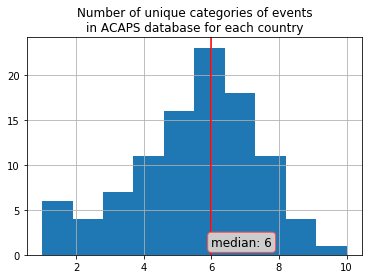

In [126]:
import matplotlib.pyplot as plt

acaps_data_summary.num_unique_keywords.hist()

median_pos = acaps_data_summary.num_unique_keywords.median()
plt.title('Number of unique categories of events\nin ACAPS database for each country')
def plot_median(med_pos):
    plt.axvline(x=med_pos,color='red')
    plt.text(median_pos, 1, 'median: ' + str(int(med_pos)), fontsize=12,
             horizontalalignment='left',
            bbox=dict(boxstyle="round",
                       ec=(1.0, 0.3, 0.3),
                       fc=(0.8, 0.8, 0.8)))
    
plot_median(median_pos)
plt.show()

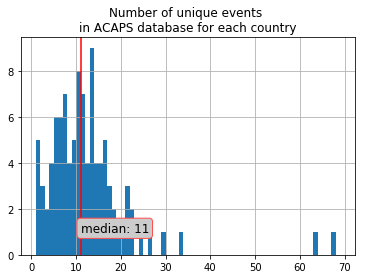

In [127]:
import matplotlib.pyplot as plt

acaps_data_summary.num_unique_events.hist(bins=range(1,70))
plt.title('Number of unique events \nin ACAPS database for each country')
median_pos = acaps_data_summary.num_unique_events.median()
plot_median(median_pos)

plt.show()

#### How does this compare?

In [121]:
ef_regions = ef_cm.Country.unique()
ef_countries = ef_regions[[s.find('US:')!=0 for s in ef_regions]] #exclude US 
len(ef_countries)

96

In [122]:
ef_countries

array(['Austria', 'Germany', 'United Kingdom', 'Vietnam', 'South Korea',
       'Singapore', 'Israel', 'Japan', 'Sweden', 'San Marino', 'Slovenia',
       'Canada', 'Hong Kong', 'Taiwan', 'Macau', 'China', 'United States',
       'European Union', 'Thailand', 'Italy', 'Czechia', 'Australia',
       'Trinidad and Tobago', 'Qatar', 'North Korea', 'New Zealand',
       'Colombia', 'Romania', 'France', 'Portugal', 'Spain', 'Belgium',
       'Luxembourg', 'Albania', 'Andorra', 'Azerbaijan', 'Belarus',
       'Bosnia and Herzegovina', 'Bulgaria', 'Denmark', 'Estonia',
       'Cyprus', 'Croatia', 'Finland', 'Georgia', 'Hungary', 'Latvia',
       'Lithuania', 'Greece', 'Moldova', 'Malta', 'Monaco', 'Netherlands',
       'Iceland', 'Guernsey', 'Macedonia', 'Ireland', 'Vatican City',
       'Jersey', 'Kosovo', 'Kazakhstan', 'Poland', 'Turkey', 'Ukraine',
       'Slovakia', 'Serbia', 'Switzerland', 'Norway', 'Montenegro',
       'Iran', 'Liechtenstein', 'Russia', 'Mexico', 'Egypt', 'Palestine',
 

In [124]:
ef_data_summary = (ef_cm
    .loc[ef_cm.Country.isin(ef_countries),:]
     .groupby('Country').apply(my_agg).reset_index()
     )

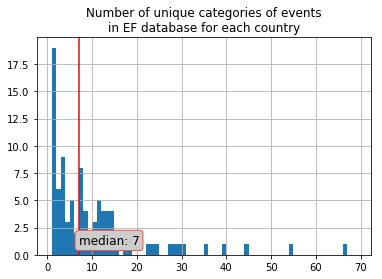

In [131]:
ef_data_summary.num_unique_keywords.hist(bins=range(1,70))
median_pos = ef_data_summary.num_unique_keywords.median()
plt.title('Number of unique categories of events\nin EF database for each country')
plot_median(median_pos)
plt.show()

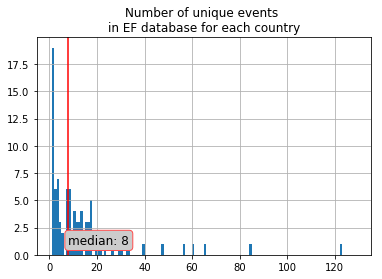

In [136]:
ef_data_summary.num_unique_events.hist(bins=range(1,130))
plt.title('Number of unique events \nin EF database for each country')
median_pos = ef_data_summary.num_unique_events.median()
plot_median(median_pos)

plt.show()

## Is the data high quality?

Let's take a look at the most common categories in the ACAPS to EF data, and based on the full-text description, manuallly judge whether the categorization makes sense. Top 3 are:

 - international travel ban - risk countries	63.0	484.0
 - hospital specialisation - partial	NaN	455.0
 - blanket curfew - no symptoms

In [182]:
from IPython.display import display, Markdown, Latex


def show_sample_of_rows_by_country(keyword,dataset):
    country_sample = np.random.choice(dataset[dataset.Keywords==keyword].Country.unique(),5)
#    print(np.random.choice(ef_from_acaps_unique.Country.unique(),5))
    sample_rows = dataset.loc[
        dataset.Country.isin(country_sample) &
        (dataset.Keywords == keyword),
        :]

    for country in country_sample:
        display(Markdown("#### " + country))
        for rind,row in sample_rows.loc[sample_rows.Country==country,:].iterrows():

            display(Markdown(" - " + row['Description of measure implemented']))
            
def show_sample_of_rows_by_country_acaps(keyword):
    show_sample_of_rows_by_country(keyword,ef_from_acaps_unique)
show_sample_of_rows_by_country_acaps('international travel ban - risk countries')

#### Iran

 - Cancel passenger arrivals from China to Iran 

#### Namibia

 - All foreign nationals will be banned from entering the country, effective immediately, to prevent further spread of coronavirus disease (COVID-19). The measure will remain in place for 30 days. Additionally, Namibian citizens and permanent residents will be prohibited from leaving the country, and those returning are subject to a mandatory 14-day self-quarantine. Residents seeking to enter Namibia will only be allowed entry "if their mission is critical to national interest."

#### Latvia

 - Latvians and people with residency will be able to enter and tourist will be able to leave.

 - No visas issued during emergency period

#### Tunisia

 - closure of maritime borders

 - People who travelled from China, South Korea, Iran and Italy in the previous 14 days, cannot enter the country.

 - Land and airports for commercial flights. Goods and repatriation flights still on.

#### France

 - Foreign citizens that are not permanents residents in France are banned from entering the country for 30 days

In [183]:
show_sample_of_rows_by_country_acaps('hospital specialisation - partial')

#### Micronesia

 - PRC Donates Medical Supplies & $100,000 to the FSM; “Thank You, China, For Your Great Friendship,” President Panuelo Says

 - Micronesia allocated $470,000 grant from ADB for COVID-19 response

#### Suriname

 - To finance operations under the corona virus approach, there is a provisional corona budget of SRD 5 million

#### Venezuela

 - Distribution of 3500 protection kits for the health workers of 5 hospitals. Measure taken by the government of Juan Guaido, which disputes presidency with that of Nicolas Maduro.

 - 9 millions $ to buy medicines and equipment for hospital. Measure taken by the government of Juan Guaido, which disputes presidency with that of Nicolas Maduro.

#### Belize

 - Health Regions have been advised to identify and prepare isolation areas within health facilities

#### New Zealand

 - NZ's 2020 flu vaccine campaign will be the biggest ever with 400,000 more vaccines available, compared with last year.

 - New Zealand rolls out drive-through hubs for testing Covid-19

 - To ensure everybody continues to have access to the prescription medication they need, PHARMAC are temporarily changing the amount pharmacists can dispense at any one time.
Prescriptions will be limited for all funded medicines to a 1-month supply, or a 3-month supply for oral contraceptives.
You will not have to visit your doctor or other prescriber more often.
You will not have to pay any additional charges for filling additional repeat prescriptions, the $5 co-pay for the first time will cover you for your repeats.
People will continue to be able to fill prescriptions at their local pharmacy, though you may have to visit more frequently than previously. Many pharmacies are operating delivery options for vulnerable customers.

 - Hospitals around NZ race to increase ICU capacity before it is needed

 - Pharmac eases restrictions on cancer drugs during Covid-19 pandemic

 - Call to join COVID-19 health workforce. Health and care support workers have opportunities to work across the country, in contact and non-contact roles. Some people may be able to work from home. Training will be provided by employers. 

In [184]:
show_sample_of_rows_by_country_acaps('blanket curfew - no symptoms')

#### Afghanistan

 - The Afghan Ministries of Public Health and Interior jointly announced that the city of Kabul would be placed on lockdown for 21 days due to spread of the COVID-19 coronavirus. Residents may only move outside their homes to obtain essential food and medicine; and provide caregiving. According to the government, vehicles carrying more than four passengers, as well as buses, are prohibited from traveling in and out of Kabul. 

#### Equatorial Guinea

 - Restaurants and dining rooms which provide prepared food services must close at 21:00h.

 - Under 30 day Health State of Alarm: All stores selling clothes, various materials, supermarkets, general stores, pharmacies, hair salons, and stores selling electrical goods, electrical goods, household goods and utensils must remain open in a timetable that may not extend beyond 20:00h.

#### Bolivia

 - General curfew from 17:00-6:00

 - Forced quarantine. Discotheques, bars, movie theaters, sporting events, large gatherings, gyms, amusement parks, night-time activities at event halls are closed. 

 - All public and private actvities are suspended until 15th of April, with few exceptions.

 - Financial institutions and stores are only allowed to open between 8am and 12am.

 - Extension of the lockdown to april 15th.

#### Cameroon

 - Curfew on bars and restaurant from 6pm.

#### Malaysia

 - Movement Control Order (MCO) in place from March 18-31 in place under the Prevention and Control of Infectious Diseases Act 1988 and the Police Act 1967. Government and private offices apart from those providing essential services are closed. All shops other than businesses dealing with daily essentials – such as food and pharmaceutical stores are closed. The Chief Minister of Sarawak has announced that people will only be allowed to leave their homes in order to buy daily necessities, essential goods and services.

 - From 18 - 31 March 2020, Sarawakians entering the state are subject to the 14-day Stay Home Notice, issued by the State Department of Health and they are not allowed to travel out of Sarawak throughout the 14-day MCO period.

 - On Wednesday (March 25), Prime Minister Tan Sri Muhyiddin Yassin announced that the MCO would be extended by two weeks until April 14 . The first phase of the 14-day MCO is in force from March 18 to 31.

 - A jobless man was sentenced to 9 months' jail for slapping a guard at a supermarket which was closed during the movement control order (MCO) period on March 25.

 - All markets, supermarkets, coffee shops and restaurants in Sarawak can only open from 7am to 7pm starting Tuesday (March 24), says the state disaster management committee. Supermarkets, hypermarkets, markets, pharmacies and private clinics were now required to practise social distancing in their premises. "The police will check the implementation randomly,"

 - Sarawakians must remain indoors from 7pm to 7am until March 31 (updated)

 - Ismail Sabri: Eateries, supermarkets, petrol stations and food delivery services to only operate from 8am to 8pm from April 1

 - second phase of the MCO in effect 1-14 April 

 - KL condo put under enhanced movement control order Mar 31- Apr 13. The enhanced MCO will affect 3,200 residents in the 502 condominium units and business premises in the tower.

 - MCO extended until April 28, PM announces (updated)

In [189]:
ef_cm.Keywords.value_counts()[1:50]

outdoor gatherings banned                                             72
international travel ban - risk countries                             71
school closure                                                        67
nonessential business suspension                                      45
sports cancellation                                                   38
international travel ban - all countries                              36
case reporting, first case                                            32
first case                                                            30
public announcement                                                   30
school closure, university closure                                    29
closure nonessential stores, nonessential business suspension         28
blanket isolation - no symptoms, compulsory isolation                 27
case reporting                                                        24
international traveller quarantine - risk countries

In [190]:
ef_cm.loc[ef_cm.Keywords=='hospital specialisation',: ]

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
54,NaN,NaN,South Korea,2020-03-13,NaT,Use designated public relief hospitals- where ...,NaN,NaN,NaN,hospital specialisation,NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN
290,151,NaN,Romania,2020-01-22,NaT,Romanian government announced several preventi...,NaN,NaN,NaN,hospital specialisation,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
390,255,NaN,Finland,2020-03-16,2020-04-13,Outsiders are forbidden from entering healthca...,NaN,NaN,NaN,hospital specialisation,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
1014,NaN,NaN,South Korea,2020-03-11,NaT,Seoul City- continuously installing and expand...,NaN,NaN,NaN,hospital specialisation,NaN,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,NaN,NaN,NaN
1109,NaN,NaN,Nepal,2020-01-23,NaT,"On 23 January, Dr. Bashudev Pandey, director o...",NaN,NaN,NaN,hospital specialisation,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
1129,NaN,NaN,Slovakia,2020-03-24,NaT,3 hospitals specialized for coronavirus patien...,NaN,NaN,NaN,hospital specialisation,2000.0,https://slovensko.hnonline.sk/2118153-nove-opa...,NaN,NaN,NaN,NaN
1150,NaN,NaN,Hungary,2020-03-16,NaT,The Honvéd Hospital will operate as a pre-exam...,NaN,NaN,NaN,hospital specialisation,1000.0,http://abouthungary.hu/news-in-brief/coronavir...,NaN,NaN,NaN,NaN
1152,NaN,NaN,Hungary,2020-03-18,NaT,Several hospitals designated as quarantine cen...,NaN,NaN,NaN,hospital specialisation,2000.0,http://abouthungary.hu/news-in-brief/coronavir...,NaN,NaN,NaN,NaN
1343,NaN,NaN,South Korea,2020-03-20,NaT,As a hospital for the general public concerned...,NaN,NaN,NaN,hospital specialisation,NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN


In [185]:
show_sample_of_rows_by_country('healthcare specialisation - partial', ef_cm)

ValueError: 'a' cannot be empty unless no samples are taken

## Save

In [37]:

combined_ds.to_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ef_acaps_combined.csv")

In [38]:
ef_from_acaps_unique.loc[ef_from_acaps_unique.Keywords=='international travel ban - risk countries']

,Keywords,confidence,Date Start,Description of measure implemented,Implementing State/Province,Country,Source,Keyword,_merge
2,international travel ban - risk countries,NaN,2020-02-24,Closure of borders with Iran,NaN,Afghanistan,"Guardian (Media, https://www.theguardian.com/g...",NaN,NaN
36,international travel ban - risk countries,NaN,2020-03-14,"Land borders: Montenegro (March 16, 2020), Kos...",NaN,Albania,"US Embassy of Albania (Government, https://al...",NaN,NaN
37,international travel ban - risk countries,NaN,2020-03-23,No ferries to and from Italy until april 3,NaN,Albania,"International SOS (Other organisations, https:...",NaN,NaN
59,international travel ban - risk countries,NaN,2020-03-17,All land borders.,NaN,Algeria,"US embassy of Algeria (Government, https://dz....",NaN,NaN
60,international travel ban - risk countries,NaN,2020-03-17,All neighboring land countries,NaN,Algeria,"US Embassy Algeria (Government, https://dz.use...",NaN,NaN
76,international travel ban - risk countries,NaN,2020-04-03,"individuals who have transited through China, ...",NaN,Angola,"GardaWorld (Other organisations, https://www.g...",NaN,NaN
77,international travel ban - risk countries,NaN,2020-01-03,Authorities are temporarily banning citizens o...,NaN,Angola,"GardaWorld (Other organisations, https://www.g...",NaN,NaN
127,international travel ban - risk countries,NaN,2020-11-03,For long term,NaN,Argentina,Ministry of Foreign Affairs - Francce (Governm...,NaN,NaN
128,international travel ban - risk countries,NaN,2020-03-15,For non-residents and travellers from the Sche...,NaN,Argentina,Ministry of Foreign Affairs - France (Governme...,NaN,NaN
140,international travel ban - risk countries,NaN,2020-03-26,Border closure is extended until 31st of March.,NaN,Argentina,"MoH (Government, https://www.boletinoficial.go...",NaN,NaN
